Goal: measure how correlated certain features of the policy $\pi_0$ are to the value $P(URS | \pi=\pi_0)$, where $URS$ indicates that the policy was optimized for a random reward function $R \in U[-1,1]^{|T|}$ (where $|T|$ is the number of transitions with non-zero probability). For simplicity's sake, we assume that it was either optimized for some $R$ or generated uniformly randomly from the set of all policies, with a 50% chance of each scenario. We also assume that the reward is generated i.i.d. via $R(s, a, s') \sim N(0, 1)$.

We can also analyze $P(USS | \pi = \pi_0)$ where $USS$ consists of sampling a sparsity factor $k \in [1, |T|]$, then zeroing out $k$ values from a randomly sampled $R$ as before.

***For outside observers: see the bottom two cells for how the graphs in our report were generated***

In [1]:
import mdptoolbox as mdpt, numpy as np
import mdptoolbox.example
import matplotlib.pyplot as plt

In [2]:
### Generate a bunch of MDPs with different parameters, sparsity
from functools import partial

NUM_MDPs = 100
NUM_STATES = 10
NUM_ACTIONS = 4

def get_transition_matrix(num_states, num_actions, generator = np.random.dirichlet, **kwargs):
    """
    Returns a determinstic transition matrix for a given number of states and actions
    
    Returns:
        P: (num_actions, num_states, num_states) array, where P[a, s, s'] is the probability of 
        transitioning from state s to state s' given action a
    """
    P = np.zeros((num_actions, num_states, num_states)) # (A, S, S') shape
    for a in range(num_actions):
        for s in range(num_states):
            P[a, s, :] = generator(np.ones(num_states))
    return P

NEAR_ZERO = 0.0001
def get_reward_matrix(transitions, sparsity = 0.0, generator = partial(np.random.uniform, -1, 1), **kwargs):
    """
    Returns a reward matrix for a given number of states and actions
    [3/16/24 edit: made sparse rewards near-zero to avoid ties, simulate uniformly sampling
    the optimal policy]
    """
    num_pos_transitions = np.count_nonzero(transitions)
    num_sparse_rewards = max(1, int(sparsity * num_pos_transitions))
    rewards = np.array([(np.random.uniform(-1.0 * NEAR_ZERO, NEAR_ZERO) 
                         if i < num_sparse_rewards else generator()) for i in range(num_pos_transitions)])
    np.random.shuffle(rewards) # create a random permutation of the rewards
    # num_pos_transitions number of rewards, with num_sparse_rewards number of zeros
    out = np.zeros(transitions.shape)
    i = 0
    for a, s, s_prime in np.argwhere(transitions):
        out[a, s, s_prime] = rewards[i]
        i += 1
    # assert (np.abs(out) < np.full(out.shape, NEAR_ZERO)).sum() == num_pos_transitions - num_sparse_rewards
    return out

DISCOUNT = 0.9
EPSILON = 0.01 # roughly indicates the "skill level" of the agent
MAX_ITER = 1000

In [3]:
def generate_tests(num_mdps = NUM_MDPs, sparsity_levels: np.ndarray = None, mdp_generator = mdpt.mdp.PolicyIterationModified, P_generator = None, **kwargs):
    """
    Generate a bunch of MDPs with different sparsity levels, and return the sparsity levels and the MDPs

    Args:
        sparsity_levels: a list of sparsity levels to generate MDPs with
    Returns:
        sparsity_levels: the sparsity levels used to generate the MDPs, in the same order as the MDPs
        MDPS: an array of MDPs
    """
    (max_iter, epsilon) = (kwargs['max_iter'], kwargs['epsilon']) if 'max_iter' in kwargs and 'epsilon' in kwargs else (MAX_ITER, EPSILON)
    sparsity_levels = sparsity_levels if sparsity_levels is not None else np.arange(num_mdps) / num_mdps
    sparsity_copy = sparsity_levels.copy() # defensive copy
    np.random.shuffle(sparsity_copy)
    transitions = np.array([get_transition_matrix(NUM_STATES, NUM_ACTIONS, **kwargs) if P_generator is None else P_generator(NUM_STATES, NUM_ACTIONS, **kwargs) for i in range(num_mdps)])
    
    MDPS = np.array([mdp_generator(
        transitions[i], 
        get_reward_matrix(transitions[i], sparsity_copy[i], **kwargs), 
        DISCOUNT, max_iter = max_iter) 
        for i in range(num_mdps)
    ])
    for mdp in MDPS:
        if mdp_generator == mdpt.mdp.ValueIteration:
            mdp.epsilon = epsilon
    return sparsity_copy, MDPS

We build a transition function with various settings for properties (e.g. deterministic, sparse, fixed) and train a classifier to predict P(URS | $\pi = \pi_0$) and P(USS | $\pi = \pi_0$) (baseline probability = 0.5).

In [4]:
### Generate a bunch of MDPs (with baseline/zero sparsity), solve some of them, 
# generate random policy for others

def transition_function_sparse_loops(states, actions, fixed = False, **kwargs):
    """
    Sparse transition function with guaranteed loops
    TODO: possibly implement terminal states
    """
    # print(fixed)
    rng = np.random.default_rng(seed = 0) if fixed else None
    transitions = np.zeros((actions, states, states))
    for state in range(states):
        self_loop = np.random.randint(0, actions) if not fixed else rng.integers(0, actions)
        for action in range(actions):
            if action == self_loop:
                for next_state in range(states):
                    transitions[action, state, next_state] = 1 if next_state == state else 0
            else: # sparse randomness
                transitions[action, state, :] = np.zeros(states)
                transitions[action, state, np.random.randint(states) if not fixed else rng.integers(0, states)] = 1
    return transitions

NUM_MDPs = 10000
fixed = False
#print(np.random.uniform(1.0/NUM_ACTIONS/NUM_STATES**2, 1, NUM_MDPs))
sparsity_levels = np.random.uniform(1.0/NUM_ACTIONS/NUM_STATES**2, 1.0, NUM_MDPs)
#sparsity_levels = np.zeros(NUM_MDPs)
# URS would be np.zeros(NUM_MDPs)

random_pol_indices = np.random.choice(NUM_MDPs, NUM_MDPs // 2, replace = False) # The indices of the MDPs with random policies
random_pol_set = set(random_pol_indices)
# i not in random_pol_set = random_or_rr[i] == 1, sparsity_levels[i] > 0
MDPS = generate_tests(NUM_MDPs, sparsity_levels = sparsity_levels,
                      P_generator = transition_function_sparse_loops, fixed = fixed)[1]
# print(np.ndim(MDPS[0].R))
# Problem with _bounditer in ValueIteration happening when upper uniform bound is too high/sparse

In [5]:
# print(random_pol_indices)
for i in range(NUM_MDPs): # 50% RR, 50% random
    MDPS[i].run()
for i in random_pol_indices:
    MDPS[i].policy = np.random.randint(NUM_ACTIONS, size = NUM_STATES)
policies = np.array([mdp.policy for mdp in MDPS])
# print(policies.shape)
random_or_rr = np.array([0 if i in random_pol_set else 1 for i in range(NUM_MDPs)])
# 0 if random, 1 if generated from RR

In [6]:
# print([MDPS[1].P[j] == MDPS[0].P[j] for j in range(NUM_ACTIONS)])
assert not fixed or np.all([np.all([MDPS[i].P[j] == MDPS[0].P[j] for j in range(NUM_ACTIONS)]) for i in range(NUM_MDPs)])

In [7]:
print(policies[0:10], random_or_rr[0:10])

[[1 1 0 2 1 1 2 2 0 3]
 [0 1 2 0 2 2 1 1 2 1]
 [1 2 0 1 0 1 1 2 2 3]
 [1 2 2 2 1 3 0 2 1 1]
 [1 2 0 0 3 3 0 1 1 0]
 [0 1 1 1 3 3 0 0 0 1]
 [1 3 0 1 0 1 2 1 3 1]
 [3 3 1 2 1 1 1 1 1 1]
 [3 1 1 0 2 0 1 1 1 0]
 [2 1 0 3 1 3 2 1 2 2]] [1 1 1 0 1 1 1 0 0 1]


In [8]:
### Linear Regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

def regression(X, y, test_size = 0.2, regression = LinearRegression):
    """
    Trains a linear regression model on the given data, and returns the model and test data
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    model = regression().fit(X_train, y_train)
    return model, model.predict_proba(X_test), y_test

def neural_network(X, y, test_size = 0.2, *args, **kwargs):
    """
    Trains a neural network on the given data, and returns the model and the mean squared error
    """
    def build_model():
        model = keras.Sequential([
            keras.layers.Dense(64, activation = 'relu', input_shape = [X.shape[1]]),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(64, activation = 'relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation = 'sigmoid')
        ])
        return model
    model = build_model()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, verbose = 1, 
              callbacks = [keras.callbacks.EarlyStopping(patience = 3)])
    return model, model.predict(X_test), y_test

def find_loop_dist_and_length(transitions, policy: np.ndarray, initial_state):
    """
    Computes the distance to the loop and the length of the loop for a given policy and initial state
    """
    visited_states = {}  # Using a dict for quicker lookups
    current_state = initial_state
    step = 0  # Track the number of steps taken to find the loop length directly

    while current_state not in visited_states:
        visited_states[current_state] = step
        # Simulate a transition
        current_state = np.random.choice(np.arange(len(policy)), 1, 
                                         p = transitions[policy[current_state]][current_state]).item()
        step += 1
    
    #distance to loop = visited_states[current_state]; loop length = step - visited_states[current_state]
    return visited_states[current_state], step - visited_states[current_state]

def takes_self_loop(transitions, policy: np.ndarray, initial_state):
    """ 
    Returns 1 if the policy takes a self loop, 0 otherwise
    """
    return int(transitions[policy[initial_state]][initial_state][initial_state] > 0.5)

def num_out_arrows(transitions, policy: np.ndarray, initial_state):
    """
    Returns the sum of outgoing arrows for each state that the policy visits from the 
    initial state before reaching a loop
    """
    visited_states = {}  # Using a dict for quicker lookups
    current_state = initial_state
    step = 0  # Track the number of steps taken to find the loop length directly
    out_arrows = 0
    while current_state not in visited_states:
        visited_states[current_state] = step
        # Simulate a transition
        current_state = np.random.choice(np.arange(len(policy)), 1, 
                                         p = transitions[policy[current_state]][current_state]).item()
        step += 1
        out_arrows += np.count_nonzero(transitions[policy[current_state]][current_state])
    return out_arrows

### Generate features
encoder = OneHotEncoder(categories = 'auto', sparse_output = False, drop = 'first')
# Drop first to avoid multicollinearity, large coefficients
# encoder.fit(np.arange(NUM_ACTIONS))
# print(encoder.categories_)

### Train the model
policies_encoded = encoder.fit_transform(policies)
features = np.array([np.concatenate((np.array(MDPS[i].P).flatten(), policies_encoded[i]), axis = 0)
                      for i in range(NUM_MDPs)])
# features = encoder.fit_transform(policies)
loop_lengths = np.array([[find_loop_dist_and_length(MDPS[i].P, policies[i], policies[i][j])[x] for j in range(NUM_STATES) for x in range(2)] 
                         for i in range(NUM_MDPs)])
self_loops = np.array([[takes_self_loop(MDPS[i].P, policies[i], j) for j in range(NUM_STATES)] for i in range(NUM_MDPs)])
# features = np.concatenate((features, encoder.fit_transform(loop_lengths)), axis = 1)
out_arrows = np.array([[num_out_arrows(MDPS[i].P, policies[i], j) for j in range(NUM_STATES)] for i in range(NUM_MDPs)])

In [9]:
# features = np.concatenate((encoder.fit_transform(policies), encoder.fit_transform(loop_lengths),
#                            ), axis = 1)
# print(loop_lengths[0:10])
features = np.concatenate((encoder.fit_transform(out_arrows), self_loops), axis = 1) # for interpretability
model, y_pred, y_test = regression(features, random_or_rr, regression = partial(LogisticRegression, max_iter = 1000))
print("Average cross-entropy loss:", log_loss(y_test, y_pred, normalize = True))
print("Accuracy:", np.mean([np.round(y_pred[i][0]) != y_test[i] for i in range(len(y_pred))])) 

# if round(y_pred[0]) is 0, then model thinks 1 is more likely; if 1, then 0 is more likely
# print(y_pred)
print("Baseline log loss:", log_loss(y_test, np.full(y_pred.shape, 0.5), normalize = True))
print("Model coefficients, intercept:", model.coef_, model.intercept_)
print("Sample outputs:", [(y_pred[i], y_test[i]) for i in range(10)])

Average cross-entropy loss: 0.4242370901099815
Accuracy: 0.8075
Baseline log loss: 0.6931471805599454
Model coefficients, intercept: [[ 2.29139716e-01  2.71369025e-01 -1.81463235e-02  1.40149707e-01
   3.37772153e-02 -1.05111955e-01  3.67172934e-01  4.65829088e-01
   1.44334321e-01  4.94292172e-01  5.44389596e-01  3.18374265e-01
   3.68994336e-01 -8.23722969e-02 -2.63637504e-01  1.04364362e-03
  -4.74230159e-01  1.86402780e-01  4.83622502e-01  4.11809868e-01
   3.65343330e-01  1.22506961e-01  2.57575704e-01 -2.53519511e-01
   2.54459459e-01 -7.92487994e-02 -3.59831226e-01  4.26486406e-01
   3.31888163e-01  9.78807161e-02  1.23356396e-01  1.40701274e-01
   4.99922488e-01 -2.22352209e-02 -2.77424957e-01  1.98803034e-01
   2.35890155e-01  1.84325738e-01  1.83507894e-01  4.44043182e-01
  -2.67156861e-01  2.72613864e-02  2.92922038e-01  5.04288718e-01
   4.65045168e-01  2.73819442e-01  1.43157432e-01  5.99350830e-02
  -2.45765124e-01  2.55906238e-01 -5.54790989e-01  2.30724022e-01
   3.0508

In [10]:
### Grab the five policies with the highest and lowest probabilities of being random
import networkx as nx

if fixed:
    # Generate a graph of the first MDP
    G = nx.DiGraph()
    for i in range(NUM_STATES):
        G.add_node(i)
    enumerated_edges = {}
    for i in range(NUM_ACTIONS):
        enumerated_edges[i] = []
        for j in range(NUM_STATES):
            for k in range(NUM_STATES):
                if MDPS[0].P[i][j, k] == 1:
                    G.add_edge(j, k, action = i)
                    enumerated_edges[i].append((j, k))
    edge_labels = {(u, v): f"{d['action']}" for u, v, d in G.edges(data=True)}
    pos = nx.spring_layout(G, k=0.5, iterations=20)  # k: Optimal distance between nodes. Increase/decrease to spread nodes out
    nx.draw(G, pos = pos, with_labels = True)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels = edge_labels)
    
    for i in range(NUM_ACTIONS):
        print(f"Action {i} transitions:", enumerated_edges[i])

highest_probs = np.argsort(y_pred[:, 1])[-5:]
lowest_probs = np.argsort(y_pred[:, 1])[:5]
#print("Highest probabilities:", [(y_pred[i], y_test[i]) for i in highest_probs])
for i in np.concatenate((highest_probs, lowest_probs)):
    print("Policy:", policies[i], "Probability:", y_pred[i], "Actual:", y_test[i])

Policy: [0 3 0 2 0 1 3 0 0 1] Probability: [0.0288299 0.9711701] Actual: 1
Policy: [0 0 2 3 2 1 1 1 0 2] Probability: [0.02785625 0.97214375] Actual: 0
Policy: [3 1 2 3 1 1 2 2 0 3] Probability: [0.0270854 0.9729146] Actual: 1
Policy: [2 1 0 1 0 2 0 1 0 3] Probability: [0.02530598 0.97469402] Actual: 1
Policy: [0 0 0 1 0 1 0 3 0 0] Probability: [0.02478745 0.97521255] Actual: 1
Policy: [2 1 0 0 0 3 1 0 0 0] Probability: [9.99875607e-01 1.24393101e-04] Actual: 0
Policy: [1 2 0 2 1 3 0 2 1 1] Probability: [9.99863680e-01 1.36319681e-04] Actual: 0
Policy: [1 3 0 1 0 0 1 0 2 0] Probability: [9.99862372e-01 1.37628148e-04] Actual: 0
Policy: [3 0 2 1 3 2 2 2 2 3] Probability: [9.99484443e-01 5.15557123e-04] Actual: 0
Policy: [3 3 2 3 3 3 0 1 0 3] Probability: [9.99482044e-01 5.17956280e-04] Actual: 0


- On a random deterministic MDP(s), it doesn't seem like URS is identifiable, which is perhaps to be expected as every policy is optimal for some (normalized) reward function
    - This also matches our results when looking at the distribution of optimal policies for "cloud"-y MDPs
- As a control, with MDPs with loops, passing in just the policy (which shouldn't give much information without the related MDP) gives 0.54 accuracy
    - Why not 0.50 exactly?
    - Similar results with neural network
    - This holds true when we use the label predictions for regression (model.predict), as well as the probability prediction (model.predict_proba)
- Passing in the policy with the transition function (flattened) gives 0.53 accuracy, even with the NN
    - Would likely need a graph neural network to train deep enough "circuits" to use the data of the whole transition function effectively
- Distance to loop correlates somewhat well with P(URS) (~0.66-0.68 accuracy, 0.61-0.63 log loss on a diverse dataset of sparse transition functions), length of loop not as well (~0.56 accuracy, 0.687 log loss)
    - Putting them together doesn't give improvement (~0.67-0.71 accuracy, 0.57-0.62 log loss)
    - Intuitively, the length of the loop an optimal policy takes is its “goal complexity”; distance to loop = “agency” 
- Setting $k \in U[1, N/2]$ gives:
    - 0.56 accuracy, 0.688 log loss with length of loop; 0.66-0.672 accuracy, 0.61 log loss with distance to loop
    - Setting the upper bound of $k$ too high results in some weird MDP package errors, I suspect because sparsity is too high
    - This matches the distribution results we found in reward_function.ipynb, as sparsity didn't seem to "matter" until around ~0.9 given (S, A) = (10, 4)
- $k \in U[1, N]$ gives similar results
    - (Note that this was run with PolicyIterationModified instead of ValueIteration with the same settings, which I don't expect to change any of the results, but I might be wrong)
    - 0.72-0.74 accuracy with policy, distance to loop, and length of loop
- Calculating whether the policy enters a self loop or not for each state $s$ gives 0.80 accuracy, 0.43 log loss!
    - With policy and distance to loop included, ~0.82-0.84 accuracy, 0.38-0.40 log loss
    - Similar results with neural network
    - The logistic coefficients are all negative, lending evidence to the claim that a policy that takes more self-loops is *less* likely to be sampled via URS or USS
        - 0.9999 chance of being from UPS if the policy always takes self-loops; 0.95 chance of being from URS/USS if it never takes self-loops
- Calculating out-arrows also gives ~0.80 accuracy, 0.44 log loss
    - Combining with self-loops doesn't give much
    - Coefficients are positive --> a policy that reaches more out-arrows is more likely to be sampled via URS or USS
- P(USS) / P(URS) is really difficult (basically 0.5)
- Graph results (see plt plot below) fits for P(USS) given uniform k, P(URS)
- Apparently when there is only one reward, passing in policy is *more* predictive than LL or O,S (.77 acc, .45 LL)

In [11]:
### Visualize the model's performance
### This is the cell that generated the plots in our reports

num_runs = 90
accuracies = np.zeros((num_runs // 3, 3))
log_losses = np.zeros((num_runs // 3, 3))

NUM_MDPs = 10000
fixed = False
#print(np.random.uniform(1.0/NUM_ACTIONS/NUM_STATES**2, 1, NUM_MDPs))
sparsity_levels = np.random.uniform(1.0/NUM_ACTIONS/NUM_STATES**2, 1.0, NUM_MDPs)
# sparsity_levels = np.random.uniform(1.0 - 1.0/NUM_ACTIONS/NUM_STATES**2, 1.0, NUM_MDPs) #high sparsity
# sparsity_levels = np.zeros(NUM_MDPs) #no sparsity

random_pol_indices = np.random.choice(NUM_MDPs, NUM_MDPs // 2, replace = False) 
# The indices of the MDPs with random policies (or random dense rewards)
random_pol_set = set(random_pol_indices)
# i not in random_pol_set = random_or_rr[i] == 1, sparsity_levels[i] > 0

# to measure P(USS) / P(URS), 
# let sparsity_levels = [sparsity_levels[i] if i in random_pol_set else 0 for i in range(NUM_MDPs)]
MDPS = generate_tests(
    NUM_MDPs, sparsity_levels = sparsity_levels,
    P_generator = transition_function_sparse_loops, fixed = fixed
)[1]

# print(random_pol_indices)
for i in range(NUM_MDPs): # 50% RR, 50% random
    MDPS[i].run()
USS_URS = False
if not USS_URS:
    for i in random_pol_indices: #comment out when measuring P(USS) / P(URS)
        MDPS[i].policy = np.random.randint(NUM_ACTIONS, size = NUM_STATES)
policies = np.array([mdp.policy for mdp in MDPS])
# print(policies.shape)
random_or_rr = np.array([0 if i in random_pol_set else 1 for i in range(NUM_MDPs)])
# 0 if random, 1 if generated from RR

encoder = OneHotEncoder(categories = 'auto', sparse_output = False, drop = 'first')

# features = encoder.fit_transform(policies)
loop_lengths = np.array([[find_loop_dist_and_length(MDPS[i].P, policies[i], policies[i][j])[x] for j in range(NUM_STATES)
                           for x in range(2)] for i in range(NUM_MDPs)])
self_loops = np.array([[takes_self_loop(MDPS[i].P, policies[i], j) for j in range(NUM_STATES)] for i in range(NUM_MDPs)])
# features = np.concatenate((features, encoder.fit_transform(loop_lengths)), axis = 1)
out_arrows = np.array([[num_out_arrows(MDPS[i].P, policies[i], j) for j in range(NUM_STATES)] for i in range(NUM_MDPs)])

for n in range(num_runs):
    ### Train the model
    policies_encoded = encoder.fit_transform(policies)
    features = np.array([np.concatenate((np.array(MDPS[i].P).flatten(), policies_encoded[i]), axis = 0)
                        for i in range(NUM_MDPs)])

    if n % 3 == 2:
        features = np.concatenate((encoder.fit_transform(out_arrows), self_loops), axis = 1) # for interpretability
    elif n % 3 == 1:
        features = encoder.fit_transform(loop_lengths)
    model, y_pred, y_test = regression(features, random_or_rr, regression=partial(LogisticRegression, max_iter=MAX_ITER))
    accuracy = np.mean([np.round(y_pred[i][0]) != y_test[i] for i in range(len(y_pred))])
    log_loss_value = log_loss(y_test, y_pred, normalize=True)
    accuracies[n // 3][n % 3] = accuracy
    log_losses[n // 3][n % 3] = log_loss_value

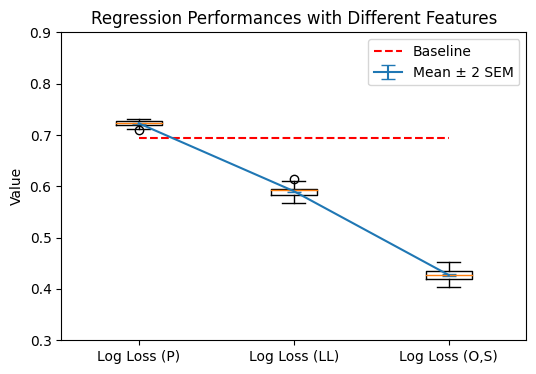

In [18]:
plt.figure(figsize=(6, 4))
data = log_losses
plt.boxplot(
    data,
    labels=['Log Loss (P)', 'Log Loss (LL)', 'Log Loss (O,S)']
)
plt.errorbar(
    np.arange(1, 4),
    np.mean(data, axis=0),
    yerr=np.std(data, axis=0) / np.sqrt(data.shape[0]),
    capsize = 5, 
    label = "Mean ± 2 SEM"
)
baseline = 0.5 if data is accuracies else 0.6931
plt.plot(np.arange(1, 4), np.full(data.shape[1], baseline), 'r--', label = "Baseline")
plt.title('Regression Performances with Different Features')
plt.ylabel('Value')
plt.ylim(0.3, 0.9)
plt.legend()
plt.show()

In [13]:
M = get_reward_matrix(transition_function_sparse_loops(10, 4), 1.0 - 1.0/NUM_ACTIONS/NUM_STATES**2/2)
print(sum([abs(m) > NEAR_ZERO for m in M.flatten()]))
print(np.count_nonzero(M))

1
40


In [14]:
np.array([x for pair in zip(accuracies.T, log_losses.T) for x in pair]).T.shape

(30, 6)

In [15]:
import pickle
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

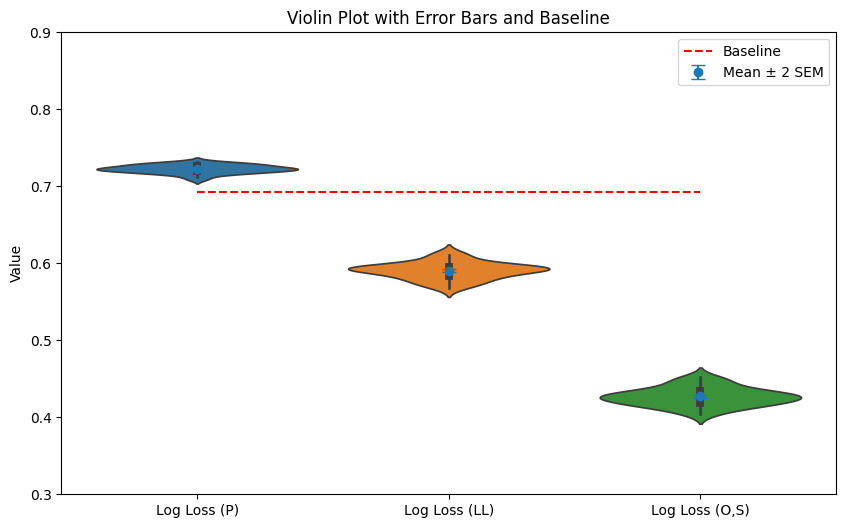

In [21]:
# Violin plot with error bars and baseline
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.violinplot(data=log_losses)
means = np.mean(log_losses, axis=0)
sems = np.std(log_losses, axis=0) / np.sqrt(log_losses.shape[0])
plt.errorbar(np.arange(3), means, yerr=sems, fmt='o', capsize=5, label="Mean ± 2 SEM")
plt.plot(np.arange(3), np.full(log_losses.shape[1], baseline), 'r--', label="Baseline")
plt.title('Violin Plot with Error Bars and Baseline')
plt.ylabel('Value')
plt.ylim(0.3, 0.9)
plt.xticks([0, 1, 2], ['Log Loss (P)', 'Log Loss (LL)', 'Log Loss (O,S)'])
plt.legend()
plt.show()